In [1]:
import random
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from deap import base, creator, tools

from matplotlib import pyplot as plt

In [2]:
dataset = pd.read_csv('dataset.csv', delimiter=';', low_memory='False')

In [3]:
#Drop columns that are not needed
dataset = dataset.drop(['user','gender','age','how_tall_in_meters','weight','body_mass_index'], axis=1)

In [4]:

#Centering
scaler = StandardScaler(with_mean=True, with_std=False)
dataset[['x1','y1','z1','x2','y2','z2','x3','y3','z3','x4','y4','z4']] = scaler.fit_transform(dataset[['x1','y1','z1','x2','y2','z2','x3','y3','z3','x4','y4','z4']])


In [5]:
#Getting the means
means = dataset.groupby('Class')[['x1','y1','z1','x2','y2','z2','x3','y3','z3','x4','y4','z4']].mean()


In [6]:
#Separating means for the sitting state and the other states
sitting_mean = means.T.pop('sitting').T
states_means = means.T.drop('sitting', axis=1).T

sitting_mean

x1    -0.486084
y1   -22.306565
z1    43.635725
x2    28.910872
y2    -3.106982
z2    87.851017
x3     5.975411
y3   -16.033985
z3    -1.506830
x4    35.909071
y4   -17.211905
z4    -2.330129
Name: sitting, dtype: float64

In [7]:
states_means

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4
Class,,,,,,,,,,,,
sittingdown,4.760175,8.224046,-22.260180,-5.823379,-13.600041,7.620686,-8.966171,1.685927,3.775952,-15.432958,-3.437820,18.822701
standing,0.157898,9.454739,-13.615081,69.255961,105.897156,30.120579,5.579103,3.606117,5.904483,-10.540946,7.306341,2.334467
standingup,1.233943,3.038834,-26.903694,-14.638464,-22.975549,-3.290510,-24.499793,-47.574437,-10.894834,-27.935515,0.165405,5.767685
walking,-1.255743,12.595985,-22.288397,-103.568370,-101.704300,-136.530879,-3.609479,27.925607,-2.599721,-18.194113,12.997469,-6.610483


In [8]:
states_means = np.array(states_means)
sitting_mean = np.array(sitting_mean)


In [9]:
#Making the genetic algorithm

w = []
for _ in range(0,12):
    w.append(1.0)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)


toolbox = base.Toolbox()
toolbox.register("attribute", random.randint, -617,533)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attribute, n=12)
                 
toolbox.register("population", tools.initRepeat, list, toolbox.individual)




def evaluate(v):
    c=0.1
    
    v= np.array(v).reshape(1,-1)
    other_states_sum = 0
    
    for state in states_means:
        other_states_sum += cosine_similarity(v,state.reshape(1,-1))
    
    f = ((cosine_similarity(v,sitting_mean.reshape(1,-1)) + c*(1 - 0.25 * other_states_sum)))/ (1 + c) + 1
    
    return f[0]



toolbox.register("mate", tools.cxSimulatedBinaryBounded, eta=0.1, low=-617, up=533)
toolbox.register("mutate", tools.mutUniformInt, low=-617,up=533, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=4)
#toolbox.register("select", tools.selRoulette)
toolbox.register("evaluate", evaluate)


    

In [10]:
def ga():
    pop = toolbox.population(n=200)
    CXPB, MUTPB, NGEN = 0.1, 0.01, 1000
    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    
    
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    
    g=0
    
    max_fits=1
    prev_max_fits=1
    max_fits_list=[]
    
    bad_improvement_counter=0
    
    best_solution=[]
        
    while g<NGEN and bad_improvement_counter<20 and max_fits<2:
        
       
        
        print("\n----GEN "+ str(g+1) +"----\n")
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        
        # Clone the selected individuals
             
        offspring =list(map(toolbox.clone, offspring))
        
        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
        
            if random.random() < CXPB:
                toolbox.mate(child1,child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values
        
        
        
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring
        
        # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values[0] for ind in pop]
        
        best_solution = pop[fits.index(max(fits))]
        
        prev_max_fits = max_fits
        max_fits = max(fits)
        max_fits_list.append(max_fits)
        
        improvement = (max_fits/prev_max_fits)-1
        
        if improvement < 0.001:
            bad_improvement_counter+=1
        else:
            bad_improvement_counter=0

        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        

        print("  Min %s" % min(fits))
        print("  Max %s" % max(fits))
        print("  Avg %s" % mean)
        print("  Std %s" % std)
        
        g+=1
        


    return best_solution, max_fits_list,g
    

In [11]:
solutions=[]
max_fits=[]
generations=[]

for _ in range(20):
    solution, max_fit,gen = ga()
    solutions.append(solution)
    max_fits.append(max_fit)
    generations.append(gen)
    
mean_fit = pd.DataFrame(max_fits).mean()



----GEN 1----

  Min 0.7996254480597645
  Max 1.6885665281613589
  Avg 1.318614065265063
  Std 0.19189122077406348

----GEN 2----

  Min 1.144158823040069
  Max 1.7353976688177606
  Avg 1.5038854209200463
  Std 0.1176094148938046

----GEN 3----

  Min 1.2075416154093388
  Max 1.7789192324360692
  Avg 1.610103068379396
  Std 0.08341848167980385

----GEN 4----

  Min 1.094009645972679
  Max 1.7955746091828622
  Avg 1.6852879836317933
  Std 0.058428217111153556

----GEN 5----

  Min 1.3719831802708211
  Max 1.7955746091828622
  Avg 1.720382335037985
  Std 0.04620216279924424

----GEN 6----

  Min 1.6638871004432407
  Max 1.8483727414002111
  Avg 1.7614266180717255
  Std 0.025141829850094114

----GEN 7----

  Min 1.6832179784498842
  Max 1.925420097410189
  Avg 1.7858984564961096
  Std 0.02574800207714437

----GEN 8----

  Min 1.5102168702388976
  Max 1.9415108185397236
  Avg 1.8093840433352688
  Std 0.040353702382805584

----GEN 9----

  Min 1.5790897877614067
  Max 1.9415108185397236
  

  Min 1.9609569501136623
  Max 1.9936771061405358
  Avg 1.9775024759798898
  Std 0.004323155246953616

----GEN 49----

  Min 1.8718637894462617
  Max 1.9939598275638537
  Avg 1.9797625726961576
  Std 0.012518370810583573

----GEN 50----

  Min 1.1669273174590507
  Max 1.9943432344733725
  Avg 1.982634052293219
  Std 0.05855194337100816

----GEN 51----

  Min 1.799120625753016
  Max 1.9952122165597221
  Avg 1.9921393267513179
  Std 0.013945171908251295

----GEN 52----

  Min 1.664044695009458
  Max 1.9952122165597221
  Avg 1.9915165369473662
  Std 0.024775788125375474

----GEN 53----

  Min 1.6014260529222537
  Max 1.9953081320246582
  Avg 1.9921266085682805
  Std 0.027706618593812522

----GEN 54----

  Min 1.7630445037006037
  Max 1.9953722648578665
  Avg 1.9933006368922475
  Std 0.016328450298739795

----GEN 55----

  Min 1.9939567947054655
  Max 1.9954843714530115
  Avg 1.9948662696665058
  Std 0.00036151341320962417

----GEN 56----

  Min 1.7251132623258898
  Max 1.9954843714530115


  Min 1.4384625653003877
  Max 1.9913056147738997
  Avg 1.983785229736583
  Std 0.052140944124049696

----GEN 31----

  Min 1.8309194023012907
  Max 1.9913056147738997
  Avg 1.9877623510469289
  Std 0.015542216566969642

----GEN 32----

  Min 1.9634785425061172
  Max 1.9925464545438287
  Avg 1.9898650690145658
  Std 0.0020726912886815238

----GEN 33----

  Min 1.9757285826693192
  Max 1.9925464545438287
  Avg 1.9908482005348325
  Std 0.0013615519884021088

----GEN 34----

  Min 1.8456541582494994
  Max 1.9925464545438287
  Avg 1.9906602623938738
  Std 0.010284852762876334

----GEN 35----

  Min 1.844092727458961
  Max 1.9932164172299633
  Avg 1.9902009655358208
  Std 0.013274765822876981

----GEN 36----

  Min 1.9526695574716761
  Max 1.9932164172299633
  Avg 1.9918617639935838
  Std 0.00350933270369158

----GEN 37----

  Min 1.9913056147738997
  Max 1.9932164172299633
  Avg 1.9926063485100471
  Std 0.00021363281826259806

----GEN 38----

  Min 1.9924851817747216
  Max 1.99335689903934

  Min 1.849493111378521
  Max 1.9480096308577446
  Avg 1.9464456854412626
  Std 0.007163219833908649

----GEN 55----

  Min 1.872186938995085
  Max 1.9480096308577446
  Avg 1.946722111023724
  Std 0.006557886249595153

----GEN 56----

  Min 1.4341275665717141
  Max 1.9480096308577446
  Avg 1.9413918760432711
  Std 0.04662802908875237

----GEN 57----

  Min 1.947571577899613
  Max 1.9480097532640896
  Avg 1.9479022564228297
  Std 0.0001883648908226622

----GEN 58----

  Min 1.9480096308577446
  Max 1.9480097532640896
  Avg 1.9480096326938463
  Std 1.812804499357408e-07

----GEN 59----

  Min 1.7339988809327327
  Max 1.9480097532640896
  Avg 1.946524246130849
  Std 0.016164699714092474

----GEN 60----

  Min 1.900677366020176
  Max 1.9480097532730154
  Avg 1.947772990597301
  Std 0.0033385203062639758

----GEN 61----

  Min 1.4464706574532096
  Max 1.9517113582430536
  Avg 1.944162904379695
  Std 0.037780690283994736

----GEN 62----

  Min 1.5427319749013488
  Max 1.9517113582430536
  Av

  Min 1.6744954958372924
  Max 1.963097714985588
  Avg 1.951198723526928
  Std 0.02282394654483974

----GEN 23----

  Min 1.9415413974638285
  Max 1.972690574159864
  Avg 1.95714983672663
  Std 0.0029223165030788797

----GEN 24----

  Min 1.8299214928080216
  Max 1.972690574159864
  Avg 1.9575144321310278
  Std 0.013450098501759515

----GEN 25----

  Min 1.8794886569744575
  Max 1.9777320775101994
  Avg 1.9623586892341396
  Std 0.009423518847974497

----GEN 26----

  Min 1.8525528685183033
  Max 1.9790296385033783
  Avg 1.9659202568138119
  Std 0.011057316680375089

----GEN 27----

  Min 1.8187703098574999
  Max 1.9790296385033783
  Avg 1.9689891199813503
  Std 0.01760574498174564

----GEN 28----

  Min 1.8066327340943968
  Max 1.984055269700832
  Avg 1.9723410889890536
  Std 0.014873023596527904

----GEN 29----

  Min 1.851378382729672
  Max 1.984055269700832
  Avg 1.974403977552895
  Std 0.010995494515851169

----GEN 30----

  Min 1.5153758497460061
  Max 1.991899862712251
  Avg 1.97

  Min 1.6722283201302406
  Max 1.9710554907578035
  Avg 1.9687321427351727
  Std 0.022355851536076134

----GEN 31----

  Min 1.7299095975058387
  Max 1.9715262202783659
  Avg 1.969789963370265
  Std 0.017004780620678124

----GEN 32----

  Min 1.8757264594907443
  Max 1.9715262202783659
  Avg 1.970555797024553
  Std 0.0067226535992790356

----GEN 33----

  Min 1.9709780325183615
  Max 1.972335022742378
  Avg 1.9711027994189552
  Std 0.00017130661496754567

----GEN 34----

  Min 1.6233377394764763
  Max 1.972335022742378
  Avg 1.9689858317115676
  Std 0.02554462532913985

----GEN 35----

  Min 1.9698117559651993
  Max 1.9725899089922705
  Avg 1.9714994232640004
  Std 0.0004018368535404616

----GEN 36----

  Min 1.97102286133341
  Max 1.972740107541047
  Avg 1.9718732175974534
  Std 0.0003906677111286715

----GEN 37----

  Min 1.9708346656264022
  Max 1.9736961356961356
  Avg 1.9722680139582203
  Std 0.00029863318593020236

----GEN 38----

  Min 1.817656162435556
  Max 1.9737488767351605


  Min 1.4683929316733468
  Max 1.9204178308307809
  Avg 1.9021070684401464
  Std 0.034658071597207456

----GEN 15----

  Min 1.8897133973139124
  Max 1.9204178308307809
  Avg 1.9179567036550815
  Std 0.006059750038139251

----GEN 16----

  Min 1.9187526364233638
  Max 1.9204672688895066
  Avg 1.9196091391798564
  Std 0.0004779692376426759

----GEN 17----

  Min 1.4874317306535925
  Max 1.9204672688895066
  Avg 1.9177908118502276
  Std 0.03054521813757188

----GEN 18----

  Min 1.9188443289966397
  Max 1.9206335103747811
  Avg 1.9204021880024473
  Std 0.00015852186131328164

----GEN 19----

  Min 1.9202779613790624
  Max 1.9206335103747811
  Avg 1.9204388280925506
  Std 3.975113705817702e-05

----GEN 20----

  Min 1.6003173150067527
  Max 1.9206335103747811
  Avg 1.9188684079773497
  Std 0.022581565684987183

----GEN 21----

  Min 1.9184675238944549
  Max 1.9206335103747811
  Avg 1.9204911668623668
  Std 0.00020260181874058247

----GEN 22----

  Min 1.8818954721749042
  Max 1.9206875209

  Min 1.7611036517186949
  Max 1.9752339142615134
  Avg 1.9300219784106003
  Std 0.027639846762583117

----GEN 16----

  Min 1.7186149378360964
  Max 1.9818552001053291
  Avg 1.953962142803039
  Std 0.02487658180174882

----GEN 17----

  Min 0.9993639716840184
  Max 1.9818552001053291
  Avg 1.9598535974901576
  Std 0.06843578396100033

----GEN 18----

  Min 1.8688010533888377
  Max 1.9818552001053291
  Avg 1.9669830446221852
  Std 0.011073642165901594

----GEN 19----

  Min 1.6713122773840885
  Max 1.9853653750562374
  Avg 1.9721082252149884
  Std 0.02609167977878469

----GEN 20----

  Min 1.950210046518997
  Max 1.9853653750562374
  Avg 1.980839525420039
  Std 0.0031022655571011745

----GEN 21----

  Min 1.771584361671007
  Max 1.9887478428559136
  Avg 1.981154696564692
  Std 0.01491615183419178

----GEN 22----

  Min 1.9418317883082148
  Max 1.9887768128867713
  Avg 1.9831339522620508
  Std 0.0035311809748055736

----GEN 23----

  Min 1.7438429837705023
  Max 1.9887478428559136
  Avg

  Min 1.8231827216270646
  Max 1.9523870373824228
  Avg 1.9498184726061552
  Std 0.009049485083458524

----GEN 47----

  Min 1.9447627958240137
  Max 1.9523870373824228
  Avg 1.9514766977111
  Std 0.0008442881807249234

----GEN 48----

  Min 1.4740255400905315
  Max 1.9523870373824228
  Avg 1.9483978956238477
  Std 0.03669195040849516

----GEN 49----

  Min 1.8811248628102604
  Max 1.9524092068683092
  Avg 1.951683045104592
  Std 0.005011563014979645

----GEN 50----

  Min 1.6038178682572821
  Max 1.9524092068683092
  Avg 1.9501060225271454
  Std 0.025496182321076883

----GEN 51----

  Min 1.4755494898235677
  Max 1.9524092068683092
  Avg 1.9496970015129869
  Std 0.03375166785038626

----GEN 52----

  Min 1.7624754129624107
  Max 1.9524098579713391
  Avg 1.951438861362125
  Std 0.013395329321398683

----GEN 53----

  Min 1.4929912864007355
  Max 1.9524098579713391
  Avg 1.9491265455449556
  Std 0.03487573258552695

----GEN 54----

  Min 1.9369768330064292
  Max 1.9524098579713391
  Avg

  Min 1.119891884435357
  Max 1.9057700122975225
  Avg 1.8171548972057334
  Std 0.05930353063966798

----GEN 8----

  Min 1.7541469338347457
  Max 1.934499797076979
  Avg 1.8540953309320982
  Std 0.026329488093663322

----GEN 9----

  Min 1.7796329742714545
  Max 1.934499797076979
  Avg 1.8789137266362053
  Std 0.022405857157659474

----GEN 10----

  Min 1.7831150887169724
  Max 1.9528751461799914
  Avg 1.8951052850852608
  Std 0.02217641619898237

----GEN 11----

  Min 1.6741995129280514
  Max 1.9528751461799914
  Avg 1.9087944308995668
  Std 0.028839067402519476

----GEN 12----

  Min 0.6090021008671801
  Max 1.9579082617210246
  Avg 1.9242784532225579
  Std 0.09596702964268355

----GEN 13----

  Min 1.459971791356598
  Max 1.9579082617210246
  Avg 1.9394685928150408
  Std 0.03582898433395402

----GEN 14----

  Min 1.1140381932601606
  Max 1.9632716628006674
  Avg 1.9444543605389495
  Std 0.06597333053219334

----GEN 15----

  Min 1.6761366405378966
  Max 1.9650455270895786
  Avg 1.9

  Min 1.9063542355971663
  Max 1.9363660024722518
  Avg 1.9353344360785867
  Std 0.0020636582061002453

----GEN 31----

  Min 1.5139669416283468
  Max 1.9365737175952302
  Avg 1.9311389113412474
  Std 0.03747349644266673

----GEN 32----

  Min 1.9332581999017977
  Max 1.9383581596409545
  Avg 1.9358822447437996
  Std 0.000494186379677266

----GEN 33----

  Min 1.8995258423090506
  Max 1.9383581596409545
  Avg 1.9361801858332035
  Std 0.0026309210835140794

----GEN 34----

  Min 1.6218420205726862
  Max 1.938394302215496
  Avg 1.9349535256389052
  Std 0.02223499535839471

----GEN 35----

  Min 1.929632923885709
  Max 1.9431312760410329
  Avg 1.93720435666325
  Std 0.0011647440062624533

----GEN 36----

  Min 1.7018337277994768
  Max 1.9431312760410329
  Avg 1.93656863480249
  Std 0.01751257522314525

----GEN 37----

  Min 1.763536207435435
  Max 1.9431312760410329
  Avg 1.9375961356000124
  Std 0.01238438443602806

----GEN 38----

  Min 1.6748992858915546
  Max 1.9431312760410329
  Avg 

  Min 1.9133714178820083
  Max 1.967284767550769
  Avg 1.9627564751401365
  Std 0.005193591248086285

----GEN 32----

  Min 1.8771316437334824
  Max 1.9713503370644205
  Avg 1.9634700076303517
  Std 0.00919362118149918

----GEN 33----

  Min 1.9470335328226756
  Max 1.9713503370644205
  Avg 1.9656867914213414
  Std 0.002121973756483566

----GEN 34----

  Min 1.9602546139628019
  Max 1.9738358299273502
  Avg 1.9668748209207836
  Std 0.001341426296835096

----GEN 35----

  Min 1.4332603753043986
  Max 1.9738358299273502
  Avg 1.9653354657062088
  Std 0.037784973179298346

----GEN 36----

  Min 1.8995127306525514
  Max 1.9738358299273502
  Avg 1.9690008069311977
  Std 0.009087596192722897

----GEN 37----

  Min 1.5984244519754591
  Max 1.9842764509908761
  Avg 1.9698279633160987
  Std 0.026609048537979175

----GEN 38----

  Min 1.9670279463882197
  Max 1.986344671900966
  Avg 1.97375914061892
  Std 0.0027626175171771307

----GEN 39----

  Min 1.3601297368806309
  Max 1.986344671900966
  A

  Min 1.9026674271436168
  Max 1.9490384911455232
  Avg 1.9357353818931626
  Std 0.011695212377439118

----GEN 34----

  Min 1.283830967871877
  Max 1.9566688260248646
  Avg 1.942266831567684
  Std 0.047323613696028395

----GEN 35----

  Min 1.8341689877346194
  Max 1.9566688260248646
  Avg 1.9478024265338119
  Std 0.008227970049326334

----GEN 36----

  Min 1.8904798299047332
  Max 1.9573467426142632
  Avg 1.9487528003997192
  Std 0.006796719917461469

----GEN 37----

  Min 1.552261163600001
  Max 1.96419582025367
  Avg 1.9469438031075623
  Std 0.035925078065655036

----GEN 38----

  Min 1.9350563913049803
  Max 1.96419582025367
  Avg 1.954971119567114
  Std 0.0037340455918264816

----GEN 39----

  Min 1.9444472814577143
  Max 1.96419582025367
  Avg 1.9572224086586099
  Std 0.0022316540786333147

----GEN 40----

  Min 1.804935872903667
  Max 1.9642319370997923
  Avg 1.958241407347585
  Std 0.01303367022485914

----GEN 41----

  Min 1.9566688260248646
  Max 1.9749969162979193
  Avg 1.9

  Min 1.9418442057240868
  Max 1.9826302468338854
  Avg 1.9626909252556057
  Std 0.0022751432583069733

----GEN 40----

  Min 1.5282000634598356
  Max 1.9826302468338854
  Avg 1.9616025876178134
  Std 0.030814966304417872

----GEN 41----

  Min 1.8620677741886078
  Max 1.9826302468338854
  Avg 1.9654130541400041
  Std 0.0086253013427341

----GEN 42----

  Min 1.963676859607577
  Max 1.9826302468338854
  Avg 1.9692523739886416
  Std 0.007041580523368099

----GEN 43----

  Min 1.890532461194398
  Max 1.9828555955303764
  Avg 1.9761340976506083
  Std 0.009954431003375707

----GEN 44----

  Min 1.1331659720428204
  Max 1.9828555955303764
  Avg 1.9781078452667646
  Std 0.059920423039806305

----GEN 45----

  Min 1.9825581709563551
  Max 1.9829716018929622
  Avg 1.9826378976503378
  Std 4.3044283587831e-05

----GEN 46----

  Min 1.8006574810606422
  Max 1.9829716018929622
  Avg 1.9800459545873488
  Std 0.01904724388312561

----GEN 47----

  Min 1.718413349484484
  Max 1.9829716018929622
  Av

  Min 1.9737806521318983
  Max 1.9757749879161621
  Avg 1.975131313175285
  Std 0.00017735488628452752

----GEN 54----

  Min 1.8981636836864269
  Max 1.9757749879161621
  Avg 1.974836911689228
  Std 0.005437773933537249

----GEN 55----

  Min 1.9745145510725592
  Max 1.975930319192245
  Avg 1.9753660752607425
  Std 0.00015187767739669968

----GEN 56----

  Min 1.975103408626129
  Max 1.975933966881809
  Avg 1.9754988757662733
  Std 0.00015806068445138453

----GEN 57----

  Min 1.9568717235307982
  Max 1.975933966881809
  Avg 1.9755611034583376
  Std 0.0013418098778563774

----GEN 58----

  Min 1.9752694324721998
  Max 1.976165598174145
  Avg 1.9758232511051126
  Std 0.00011054515991921884

----GEN 59----

  Min 1.9755832780868512
  Max 1.976165598174145
  Avg 1.9759197554872316
  Std 5.997084094016138e-05

----GEN 60----

  Min 1.8790250757549551
  Max 1.976165598174145
  Avg 1.9754737416241963
  Std 0.006837303055199837

----GEN 61----

  Min 1.140920763544275
  Max 1.976211648060005

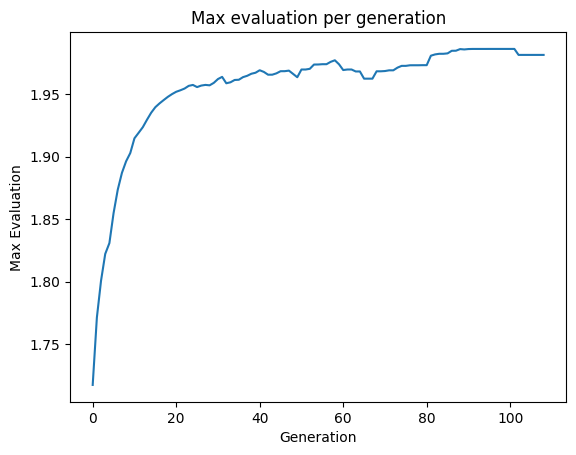

In [19]:
experiment_name = "exp_1"
experiment_path = "Experiments/"+experiment_name+"/"

if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)

plt.title("Max evaluation per generation")
plt.xlabel("Generation")
plt.ylabel("Max Evaluation")
plt.plot(mean_fit)
plt.savefig(experiment_path+experiment_name+".jpg")

In [15]:
f = open(experiment_path+experiment_name+"_gens.txt","w")
f.write("Mean number of generations: " +str(np.mean(generations)))
f.close()

<function TextIOWrapper.close()>

In [17]:
best_solution = solutions[max_fits.index(max(max_fits))]
np.savetxt(experiment_path+experiment_name+"_solution.txt", best_solution, delimiter=',')